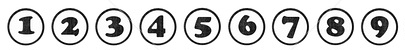
# Digit Recognizer

## Overview
This competition uses the most basic mnist data in deep learning. We need to create a model to classify the numbers in the image. <br/>
You can use other techniques instead of deep learning. However, this notebook will be written based on deep learning. <br/>
In addition, we will use "Pytorch" among the frameworks that enable deep learning.

#### My opinion :
* 1) I think it is important to use various techniques and get used to deep learning through this competition.

***
## My Workflow

#### 1. Import & Install libray
* Import Basic libray
* Import Enginnering libray

#### 2. Check out my data
* Check Shape / Info / Describe

#### 3. Exploratory Data Analysis(EDA) with Visualization [Before Preprocessing]
* Plot the null values
* Plot the label Percent
* Plot the image Data

#### 4. Feature Enginnering
* Split Train set / Validation set
* Convert to data suitable for CNN model (Dataset / Dataloader)

#### 5.Modeling
* CNN Modeling
* Training
* Evaluating

#### 6. Submission
* Submit the predictions.
<br/><br/>
***

# 1. Import & Install libray
* Import Basic libray
* Import Enginnering libray

In [1]:
import pandas as pd
import numpy as np
from collections import OrderedDict

from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

plt.style.use('seaborn')
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

import sklearn
from sklearn.model_selection import train_test_split

In [3]:
train_df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_df = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 2. Check out my data
* Check Shape / Info / Describe

In [4]:
print("train data shape : {}".format(train_df.shape))
print("test data shape : {}".format(test_df.shape))

train data shape : (42000, 785)
test data shape : (28000, 784)


In [5]:
train_df.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [6]:
print("Check train data values : \n{}".format(np.unique(train_df)))

Check train data values : 
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239

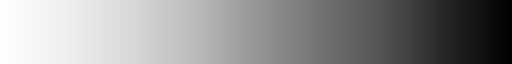

In [7]:
sns.color_palette("Greys", as_cmap=True)

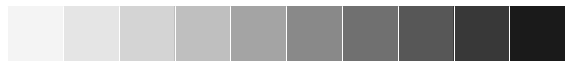

In [8]:
Greys_palette = sns.color_palette("Greys",10)
sns.palplot(Greys_palette)

# 3. Exploratory Data Analysis(EDA) with Visualization [Before Preprocessing]
* Plot the null values
* Plot the label Percent
* Plot the image Data

### 3-1) Plot the null values

In [9]:
pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False), columns=["Null Count"]).head().style.background_gradient(cmap='Greys')

,Null Count
pixel783,0
pixel267,0
pixel265,0
pixel264,0
pixel263,0


<AxesSubplot:>

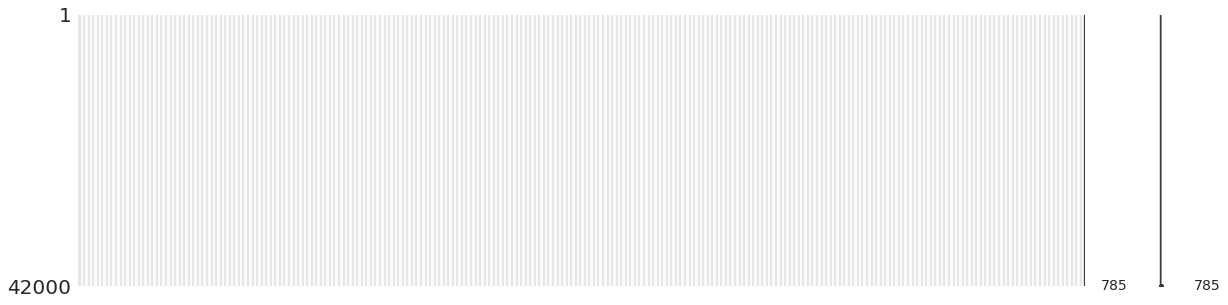

In [10]:
msno.matrix(df=train_df.iloc[:,:],figsize=(20,5),color=Greys_palette[8])

### 3-2) Plot the label Percent

Text(0.1, 0.92, 'distribution by Label in Mnist')

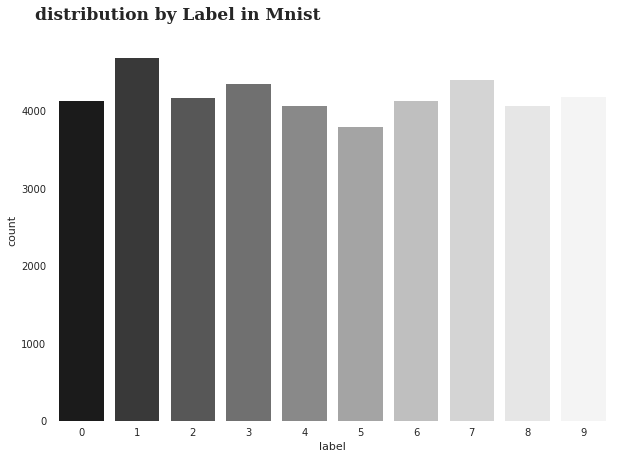

In [11]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
sns.countplot(x='label', data=train_df, palette=Greys_palette[::-1], ax=ax)
ax.patch.set_alpha(0)

fig.text(0.1,0.92,"distribution by Label in Mnist", fontweight="bold", fontfamily='serif', fontsize=17)

### 3-3) * Plot the image Data

In [12]:
x = train_df.iloc[:,1:].values
y = train_df.iloc[:,0].values

In [13]:
print("X shape : {}".format(x.shape))
print("Y shape : {}".format(y.shape))

X shape : (42000, 784)
Y shape : (42000,)


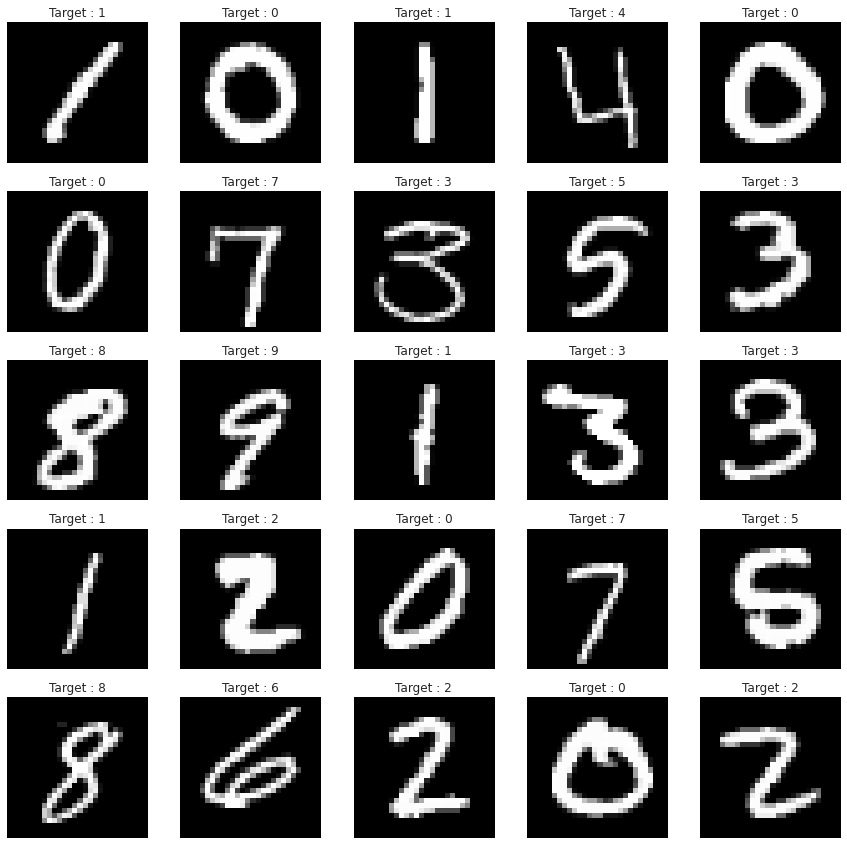

In [14]:
fig , axes = plt.subplots(5, 5, figsize=(15,15))

x_idx = 0
y_idx = 0

for i in range(5*5):
    if x_idx == 5:
        x_idx = 0
        y_idx += 1
        
    axes[y_idx][x_idx].imshow(x[i].reshape(28,28), 'gray')
    axes[y_idx][x_idx].axis("off")
    axes[y_idx][x_idx].set_title("Target : " + str(y[i]))
    x_idx += 1

plt.show()

# 4. Feature Enginnering
* Split Train set / Validation set
* Convert to data suitable for CNN model (Dataset / Dataloader)

### 4-1) Split Train set / Validation set

In [15]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15)

In [16]:
print("x_train shape : {}".format(x_train.shape))
print("y_train shape : {}".format(y_train.shape))
print("x_val shape : {}".format(x_val.shape))
print("y_val shape : {}".format(y_val.shape))

x_train shape : (35700, 784)
y_train shape : (35700,)
x_val shape : (6300, 784)
y_val shape : (6300,)


### 4-2) Convert to data suitable for CNN model (Dataset / Dataloader)

In [17]:
class BasicDataset(torch.utils.data.Dataset):
    def __init__(self,x_data, y_data, is_labeled=False):
        self.x = self.get_float_type(x_data)
        self.is_labeled = is_labeled
        
        if self.is_labeled:
            self.y = self.get_long_type(y_data)
        else:
            self.y = None
        
        
    def __len__(self):
        return len(self.x)
    
    
    def __getitem__(self, index):
        global data
        data = {}
        
        x_row = self.x[index]
        data['data'] = x_row
    
        if self.is_labeled == True: 
            y_row = self.y[index]
            data['target'] = y_row
        return data
    
        
    def get_float_type(self, data):
        data = data.astype('float32')
        data /= 255
        data = data.reshape(-1, 1, 28, 28)
        return data
    
    
    def get_long_type(self, target):
        target = target.astype(torch.LongTensor)
        return target

In [18]:
train_dataset = BasicDataset(x_train, y_train, is_labeled=True)
val_dataset = BasicDataset(x_val, y_val, is_labeled=True)

In [19]:
print("Data of train dataset : {}\n\n\n\n".format(train_dataset[0]['data']))
print("Target of train dataset : {}".format(train_dataset[0]['target']))

Data of train dataset : [[[0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0. 

In [20]:
BATCH_SIZE = 256

In [21]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle = False)

In [22]:
dataloaders_dict = {"train": train_loader, "val": val_loader}

# 5.Modeling
* CNN Modeling
* Training
* Evaluating

### 5-1) CNN Modeling

In [23]:
INPUT_DIM = 1
HIDDEN_DIM_1 = 32
HIDDEN_DIM_2 = 64
OUTPUT = 10

In [24]:
class BasicCNN(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, output):
        super(BasicCNN, self).__init__()
        
        self.convolution_layer = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(input_dim, hidden_dim_1, 3, 1, 0)),
            ('relu1', nn.ReLU()),
            ('pool1', nn.MaxPool2d(2,2)),
            ('conv2', nn.Conv2d(hidden_dim_1, hidden_dim_2, 3, 1, 0)),
            ('relu2', nn.ReLU()),
            ('pool2', nn.MaxPool2d(2,2))    
        ]))
        self.fc_layer = nn.Sequential(OrderedDict([
            ('Dense1', nn.Linear(1600, output)),
            ('softmax', nn.Softmax())
        ]))
    
    def forward(self,x):
        out = self.convolution_layer(x)
        out = out.view(out.size(0),-1)
        out = self.fc_layer(out)
        return out

In [25]:
cnn_model = BasicCNN(INPUT_DIM, HIDDEN_DIM_1, HIDDEN_DIM_2, OUTPUT)

In [26]:
print(cnn_model)

BasicCNN(
  (convolution_layer): Sequential(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (relu1): ReLU()
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu2): ReLU()
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (Dense1): Linear(in_features=1600, out_features=10, bias=True)
    (softmax): Softmax(dim=None)
  )
)


In [27]:
train_dataset[0]['data'].shape

(1, 28, 28)

In [28]:
class ResidualBlock(nn.Module):
    def __init__(self, data_dim, next_data_dim, stride, layer_name, is_last_layer=False):
        super(ResidualBlock, self).__init__()
        self.is_last_layer = is_last_layer
        
        self.resblock_1 = nn.Sequential(OrderedDict([
            ('{}_conv1'.format(layer_name), nn.Conv2d(data_dim, data_dim, kernel_size=3, stride=stride, padding=1, bias=False)),
            ('{}_batchnorm1'.format(layer_name), nn.BatchNorm2d(data_dim)),
            ('{}_relu1'.format(layer_name), nn.ReLU()),
            
            ('{}_conv2'.format(layer_name), nn.Conv2d(data_dim, data_dim, kernel_size=3, stride=1, padding=1, bias=False)),
            ('{}_batchnorm2'.format(layer_name), nn.BatchNorm2d(data_dim)),
            ('{}_relu2'.format(layer_name), nn.ReLU())
        ]))
        self.resblock_2 = nn.Sequential(OrderedDict([
            ('{}_conv1'.format(layer_name), nn.Conv2d(data_dim, data_dim, kernel_size=3, stride=stride, padding=1, bias=False)),
            ('{}_batchnorm1'.format(layer_name), nn.BatchNorm2d(data_dim)),
            ('{}_relu1'.format(layer_name), nn.ReLU()),
            
            ('{}_conv2'.format(layer_name), nn.Conv2d(data_dim, data_dim, kernel_size=3, stride=2, padding=1, bias=False)),
            ('{}_batchnorm2'.format(layer_name), nn.BatchNorm2d(data_dim)),
            ('{}_relu2'.format(layer_name), nn.ReLU())
        ]))
        
        self.set_shortcut = nn.Conv2d(data_dim, data_dim, kernel_size=3, stride=2, padding=1, bias=False)
        self.set_next_shortcut = nn.Conv2d(data_dim, next_data_dim, kernel_size=3, stride=2, padding=1, bias=False)
        
    def forward(self, x, is_last_layer=False):
        shortcut = x
        out = self.resblock_1(x)
        out = out + shortcut
        
        shortcut = self.set_shortcut(out)
        out = self.resblock_2(out)
        out = out + shortcut
        
        out = self.set_next_shortcut(out)

        return out

In [29]:
class ResNet18(nn.Module):
    def __init__(self, input_dim, output):
        super(ResNet18, self).__init__()
        self.FirstBlock = nn.Sequential(OrderedDict([
            ('FirstBlock_conv1', nn.Conv2d(input_dim, 64, kernel_size=3, stride=1, padding=1, bias=False)),
            ('FirstBlock_batchnorm1', nn.BatchNorm2d(64)),
            ('FirstBlock_relu1', nn.ReLU()),
            ('FirstBlock_maxpool2d1', nn.MaxPool2d(kernel_size=2, stride=2, padding=1)),
        ]))
        self.SecondBlock = ResidualBlock(64, 128, 1,'SecondBlock', is_last_layer=False)
        self.ThridBlock = ResidualBlock(128, 256, 1,'ThridBlock', is_last_layer=True)
        
        self.AveragePool2d = nn.AdaptiveAvgPool2d((1,1))
        
        self.FC = nn.Sequential(OrderedDict([
            ('FC_linear', nn.Linear(256, output)),
            ('FC_softmax', nn.Softmax(dim=1))
        ]))
    
    def forward(self, x):
        out = self.FirstBlock(x)
        out = self.SecondBlock(out)
        out = self.ThridBlock(out)
        out = self.AveragePool2d(out)
        out = out.view(out.size(0), -1)
        out = self.FC(out)
        
        return out

In [30]:
resnet_model = ResNet18(INPUT_DIM, OUTPUT)

In [31]:
print(resnet_model)

ResNet18(
  (FirstBlock): Sequential(
    (FirstBlock_conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (FirstBlock_batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (FirstBlock_relu1): ReLU()
    (FirstBlock_maxpool2d1): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (SecondBlock): ResidualBlock(
    (resblock_1): Sequential(
      (SecondBlock_conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (SecondBlock_batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (SecondBlock_relu1): ReLU()
      (SecondBlock_conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (SecondBlock_batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (SecondBlock_relu2): ReLU()
    )
    (resblock_2): Sequential(
      (Second

In [32]:
print("총 배치의 수 : {}".format(len(train_loader)))

총 배치의 수 : 140


### 5-2) Training

In [33]:
def train_model(model, dataloaders_dict, loss_fn, optimizer, num_epochs, filename):
    model.to(device)

    history ={'train_loss' : [],
             'train_acc' : [],
              'val_loss' : [],
              'val_acc' : []
             }
    
    for epoch in range(num_epochs):
        for i, phase in enumerate(['train','val']):
            if phase=='train':
                model.train()
            else:
                model.eval()
                
            correct = 0
            epoch_loss = 0
            epoch_acc = 0 

            for data in dataloaders_dict[phase]:
                x_data = data['data'].to(device)
                y_data = data['target'].to(device)

                optimizer.zero_grad()

                predict = model(x_data)
                target = y_data
                loss = loss_fn(predict, target)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                epoch_loss += loss.item() * len(x_data)
                correct += (target==predict.argmax(axis=1)).sum()
                    
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = 100 * (correct / len(dataloaders_dict[phase].dataset))
            print("{} : [{} / {}] Loss : {:.4f}  | Accuracy : {:.2f}%".format(phase.upper(), epoch+1, num_epochs, epoch_loss, epoch_acc))
            
            history['{}_loss'.format(phase)].append(epoch_loss)
            history['{}_acc'.format(phase)].append(epoch_acc)
            
        torch.save(model.state_dict(), filename)
        print(" ")
    return history

In [34]:
USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)
device = torch.device('cuda:0' if USE_CUDA else 'cpu')
print('A device that proceeds with : ',device)

True
A device that proceeds with :  cuda:0


* CNN Model

In [35]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.01)

In [36]:
NUM_EPOCHS = 50
SAVE_MODEL_PATH = f'cnn.pth'

history = train_model(
    cnn_model,
    dataloaders_dict,
    loss_fn, 
    optimizer,
    NUM_EPOCHS,
    SAVE_MODEL_PATH
    )

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


TRAIN : [1 / 50] Loss : 1.6460  | Accuracy : 81.73%
VAL : [1 / 50] Loss : 1.5010  | Accuracy : 96.16%
 
TRAIN : [2 / 50] Loss : 1.4948  | Accuracy : 96.75%
VAL : [2 / 50] Loss : 1.4873  | Accuracy : 97.43%
 
TRAIN : [3 / 50] Loss : 1.4847  | Accuracy : 97.69%
VAL : [3 / 50] Loss : 1.4894  | Accuracy : 97.24%
 
TRAIN : [4 / 50] Loss : 1.4828  | Accuracy : 97.85%
VAL : [4 / 50] Loss : 1.4820  | Accuracy : 97.97%
 
TRAIN : [5 / 50] Loss : 1.4812  | Accuracy : 98.00%
VAL : [5 / 50] Loss : 1.4831  | Accuracy : 97.79%
 
TRAIN : [6 / 50] Loss : 1.4793  | Accuracy : 98.18%
VAL : [6 / 50] Loss : 1.4871  | Accuracy : 97.41%
 
TRAIN : [7 / 50] Loss : 1.4791  | Accuracy : 98.18%
VAL : [7 / 50] Loss : 1.4968  | Accuracy : 96.40%
 
TRAIN : [8 / 50] Loss : 1.4797  | Accuracy : 98.13%
VAL : [8 / 50] Loss : 1.4814  | Accuracy : 97.98%
 
TRAIN : [9 / 50] Loss : 1.4776  | Accuracy : 98.36%
VAL : [9 / 50] Loss : 1.4786  | Accuracy : 98.25%
 
TRAIN : [10 / 50] Loss : 1.4759  | Accuracy : 98.53%
VAL : [10 /

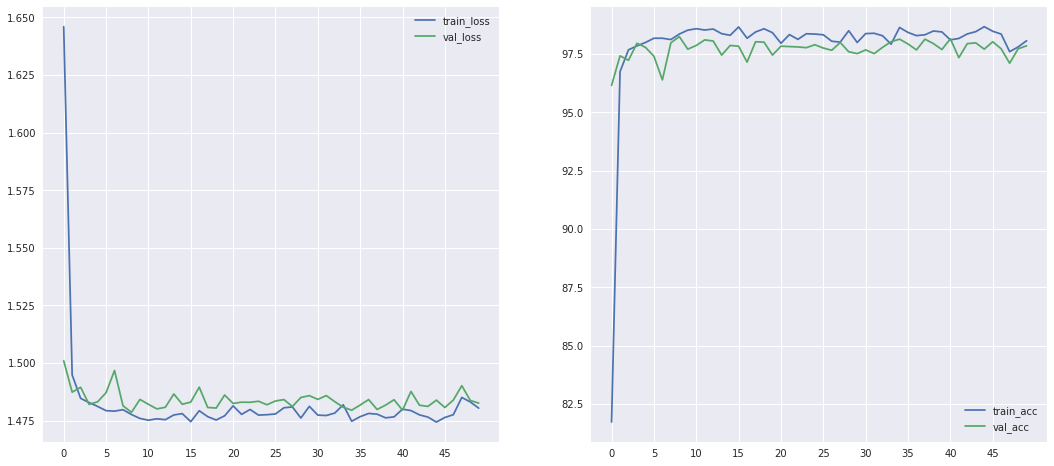

In [37]:
fig, axes = plt.subplots(1,2, figsize=(18,8))
axes[0].plot(history['train_loss'],label='train_loss')
axes[0].plot(history['val_loss'], label='val_loss')
axes[0].set_xticks(np.arange(0,NUM_EPOCHS,5))
axes[0].legend()


axes[1].plot(history['train_acc'], label='train_acc')
axes[1].plot(history['val_acc'], label='val_acc')
axes[1].set_xticks(np.arange(0,NUM_EPOCHS,5))
axes[1].legend()

plt.show()

* ResNet 18 Model

In [38]:
# Clear cache
import gc
gc.collect()

torch.cuda.empty_cache()

In [39]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.01)

In [40]:
NUM_EPOCHS = 3
SAVE_MODEL_PATH = f'resnet.pth'

history = train_model(
    resnet_model,
    dataloaders_dict,
    loss_fn, 
    optimizer,
    NUM_EPOCHS,
    SAVE_MODEL_PATH
    )

TRAIN : [1 / 3] Loss : 2.3688  | Accuracy : 9.16%
VAL : [1 / 3] Loss : 2.3659  | Accuracy : 9.52%
 
TRAIN : [2 / 3] Loss : 2.3717  | Accuracy : 8.95%
VAL : [2 / 3] Loss : 2.3659  | Accuracy : 9.52%
 
TRAIN : [3 / 3] Loss : 2.3717  | Accuracy : 8.95%
VAL : [3 / 3] Loss : 2.3659  | Accuracy : 9.52%
 


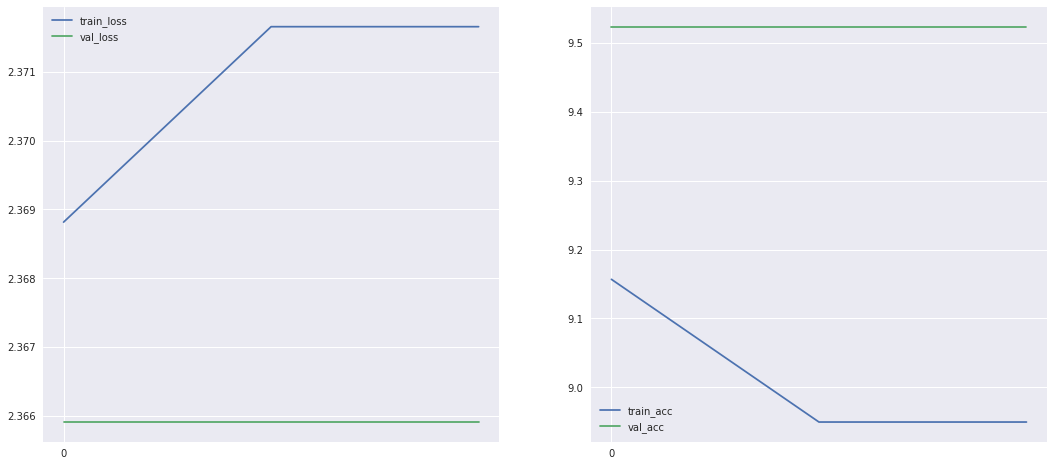

In [41]:
fig, axes = plt.subplots(1,2, figsize=(18,8))
axes[0].plot(history['train_loss'],label='train_loss')
axes[0].plot(history['val_loss'], label='val_loss')
axes[0].set_xticks(np.arange(0,NUM_EPOCHS,5))
axes[0].legend()


axes[1].plot(history['train_acc'], label='train_acc')
axes[1].plot(history['val_acc'], label='val_acc')
axes[1].set_xticks(np.arange(0,NUM_EPOCHS,5))
axes[1].legend()

plt.show()

### 5-3) Evaluating

In [42]:
def evalueate_model(model, test_loader):
    predictions = []

    #model = BasicCNN()
    #model.to(device)
    #model.load_state_dict(torch.load(f'cnn.pth'))
    
    model.eval()

    for data in test_loader:
        x_data = data['data'].to(device)
        
        with torch.no_grad():
            predicts = model(x_data)
            predicts = predicts.argmax(axis=1)
            predicts = predicts.cpu().numpy()
            
            # Put the batch size data into the list one by one.
            for pred in predicts:
                predictions.append(pred)
        
    return(predictions)

In [43]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
test_dataset = BasicDataset(test_df.values, y_data=None, is_labeled=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle = False)

In [45]:
pred = evalueate_model(cnn_model, test_loader)

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


# 6. Submission
* Submit the predictions.

In [46]:
submission = pd.read_csv('../input/digit-recognizer/sample_submission.csv')
submission['Label'] = pred
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


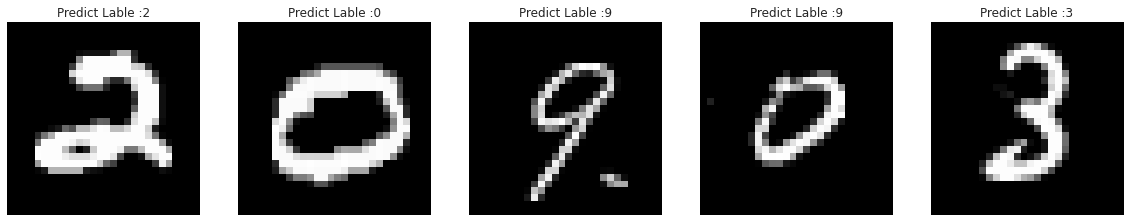

In [47]:
fig, axes = plt.subplots(1,5, figsize=(20,5))

for i in range(5):
    axes[i].imshow(test_df.iloc[i].values.reshape(28,28), 'gray')
    axes[i].axis('off')
    axes[i].set_title("Predict Lable :" + str(pred[i]))
plt.show()

In [48]:
submission.to_csv('submission.csv', index=False)

##### reference 
* https://www.kaggle.com/kanncaa1/pytorch-tutorial-for-deep-learning-lovers

###  If this notebook is useful for your kaggling, "UPVOTE" for it 👀
#### THX to Reading My Notebook🌈